In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import util
from pathlib import Path
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from class_manipulates_path import ManipulatePath
from class_preprocessing_refactor import Preprocessing
from class_format_data import FormatData
util.init()

'Módulo util importado com sucesso.'

In [2]:
def plot_variable(df, column_name):
    """
    Plota um gráfico de dispersão para uma variável de um DataFrame.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - column_name: Nome da coluna que você deseja plotar.
        - intervalos: Lista de intervalos para plotar linhas verticais.
    """
    plt.figure(figsize=(20, 10))
    plt.scatter(df.index.values, df[column_name].values, color='darkcyan', alpha=0.5)
    plt.xlabel('Índice')
    plt.ylabel(column_name)
    plt.title(f'Gráfico de dispersão para a variável "{column_name}"')

    plt.show()

In [3]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [4]:
def plot_two_variables(df, var1, var2, binary_column=None):
    """
    Plota um gráfico de dispersão para duas variáveis de um DataFrame, colorindo os pontos conforme uma coluna binária, se fornecida.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - var1: Nome da primeira variável (eixo x).
        - var2: Nome da segunda variável (eixo y).
        - binary_column: Nome da coluna binária usada para colorir os pontos (opcional).
    """
    plt.figure(figsize=(10, 6))

    if binary_column is not None:
        # Obtendo os valores únicos da coluna binária
        classes = df[binary_column].unique()

        # Criando um mapeamento de classe para cor
        colors = {cls: plt.cm.tab10(i) for i, cls in enumerate(classes)}

        # Colorindo os pontos de acordo com as classes
        for cls in classes:
            df_cls = df[df[binary_column] == cls]
            plt.scatter(df_cls[var1], df_cls[var2], color=colors[cls], label=cls, alpha=0.5)
        
        plt.legend(title=binary_column)
    else:
        plt.scatter(df[var1], df[var2], alpha=0.5)

    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'Gráfico de Dispersão: {var1} vs {var2}')
    plt.grid(True)
    plt.show()

In [5]:
def plot_variavel_e_histograma(dataframe, nome_coluna):
    # Verifica se a coluna existe no DataFrame
    if nome_coluna not in dataframe.columns:
        print("A coluna especificada não existe no DataFrame.")
        return
    
    # Plota a variável ao longo do tempo
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    dataframe[nome_coluna].plot()
    plt.title("Variação ao longo do tempo")
    plt.xlabel("Índice")
    plt.ylabel(nome_coluna)
    
    # Plota o histograma da variável
    plt.subplot(1, 2, 2)
    dataframe[nome_coluna].hist()
    plt.title("Histograma")
    plt.xlabel(nome_coluna)
    plt.ylabel("Frequência")
    
    plt.tight_layout()
    plt.show()

In [6]:
def kmeans_two_variables(df, var1, var2, n_clusters=3):
    """
    Aplica o algoritmo K-means para agrupar duas variáveis de um DataFrame.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - var1: Nome da primeira variável.
        - var2: Nome da segunda variável.
        - n_clusters: Número de clusters (padrão é 3).
    """
    # Seleciona as duas variáveis
    X = df[[var1, var2]]

    # Aplica o algoritmo K-means
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)

    # Obtém as coordenadas dos centroides
    centroids = kmeans.cluster_centers_

    # Plota os pontos e os centroides
    plt.figure(figsize=(10, 6))
    plt.scatter(X[var1], X[var2], c=kmeans.labels_, cmap='viridis', alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, color='red')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'K-means: {var1} vs {var2}')
    plt.grid(True)
    plt.show()

In [7]:
def extract_well_number(path):
    match = re.search(r'WELL-(\d+)_', path)
    if match:
        return match.group(1)
    else:
        return None

In [8]:
manipulate_path = ManipulatePath()

preprocessing = Preprocessing()

format_data = FormatData()

path_raw_data = manipulate_path.get_path_raw_data()

abnormal_classes_codes = [1, 2, 5, 6, 7, 8]

In [9]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(path_raw_data, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

In [12]:
# filtra somente arquivos da falha 1
falha = 1
real_instances = real_instances[real_instances["class_code"] == falha].copy()

In [13]:


file_paths = real_instances[real_instances["class_code"] == falha]["instance_path"].values
df_output = pd.DataFrame()

for file_path in file_paths:
    df_data = pd.read_csv(file_path)

    df_data = FormatData.set_index_dataframe(df_data=df_data,
                                         column_name="timestamp")
    quantidade = (df_data['class'] == falha).sum()
    print(f"1 se repete {quantidade}")
    print(f"Index min {df_data.index.min()} index max {df_data.index.max()}")
    
    df_output = pd.concat([df_output, df_data], axis=0)

1 se repete 4603
Index min 2014-01-24 09:33:03 index max 2014-01-25 01:47:30
1 se repete 2929
Index min 2014-01-26 16:19:44 index max 2014-01-26 23:00:00
1 se repete 1205
Index min 2017-07-31 18:09:30 index max 2017-08-01 20:45:00
1 se repete 861
Index min 2017-07-31 22:04:32 index max 2017-08-01 20:19:27
1 se repete 819
Index min 2018-06-17 20:02:57 index max 2018-06-18 11:00:00


In [14]:
df_output

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,
2014-01-24 09:33:03,0.000000e+00,18433410.0,116.8718,9397031.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:04,0.000000e+00,18433410.0,116.8718,9397031.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:05,0.000000e+00,18433410.0,116.8718,9397032.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:06,0.000000e+00,18433410.0,116.8718,9397033.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:07,0.000000e+00,18433410.0,116.8718,9397033.0,74.80031,-300917.8,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2018-06-18 10:59:56,-1.180116e+42,20647810.0,118.2188,10136700.0,71.27952,4108865.0,NaN,0.0,1.0
2018-06-18 10:59:57,-1.180116e+42,20647810.0,118.2194,10137410.0,71.27949,4108866.0,NaN,0.0,1.0
2018-06-18 10:59:58,-1.180116e+42,20647810.0,118.2201,10138120.0,71.27946,4108866.0,NaN,0.0,1.0


In [15]:
df_output = df_output[~df_output.index.duplicated()]
df_output.shape

(232040, 9)

In [16]:
for column_name in df_output.columns:
    percent = Preprocessing.check_null_dataframe(df_data=df_output, column_name=column_name)
    print(f"{column_name} null data is {percent}")

P-PDG null data is 0.0
P-TPT null data is 0.0
T-TPT null data is 0.0
P-MON-CKP null data is 0.0
T-JUS-CKP null data is 0.0
P-JUS-CKGL null data is 0.0
T-JUS-CKGL null data is 100.0
QGL null data is 0.0
class null data is 4.459575935183589


In [17]:
df_preprocessing = df_output.drop(columns=["T-JUS-CKGL"])
df_preprocessing

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class
timestamp,,,,,,,,
2014-01-24 09:33:03,0.000000e+00,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,0.0
2014-01-24 09:33:04,0.000000e+00,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,0.0
2014-01-24 09:33:05,0.000000e+00,18433410.0,116.8718,9397032.0,74.80031,-300917.8,0.0,0.0
2014-01-24 09:33:06,0.000000e+00,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,0.0
2014-01-24 09:33:07,0.000000e+00,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,0.0
...,...,...,...,...,...,...,...,...
2018-06-18 10:59:56,-1.180116e+42,20647810.0,118.2188,10136700.0,71.27952,4108865.0,0.0,1.0
2018-06-18 10:59:57,-1.180116e+42,20647810.0,118.2194,10137410.0,71.27949,4108866.0,0.0,1.0
2018-06-18 10:59:58,-1.180116e+42,20647810.0,118.2201,10138120.0,71.27946,4108866.0,0.0,1.0


In [18]:
for column_name in df_preprocessing.columns:
    percent = Preprocessing.check_column_low_variance(df_data=df_preprocessing, column_name=column_name)
    print(f"{column_name} low variance is {percent}")

P-PDG low variance is 0
P-TPT low variance is 0
T-TPT low variance is 0
P-MON-CKP low variance is 0
T-JUS-CKP low variance is 0
P-JUS-CKGL low variance is 0
QGL low variance is 1
class low variance is 0


In [19]:
df_preprocessing = df_preprocessing.drop(columns=["P-PDG", "P-JUS-CKGL", "QGL"])
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
timestamp,,,,,
2014-01-24 09:33:03,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:04,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:05,18433410.0,116.8718,9397032.0,74.80031,0.0
2014-01-24 09:33:06,18433410.0,116.8718,9397033.0,74.80031,0.0
2014-01-24 09:33:07,18433410.0,116.8718,9397033.0,74.80031,0.0
...,...,...,...,...,...
2018-06-18 10:59:56,20647810.0,118.2188,10136700.0,71.27952,1.0
2018-06-18 10:59:57,20647810.0,118.2194,10137410.0,71.27949,1.0
2018-06-18 10:59:58,20647810.0,118.2201,10138120.0,71.27946,1.0


In [20]:
df_preprocessing = df_preprocessing.dropna()

In [21]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
timestamp,,,,,
2014-01-24 09:33:03,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:04,18433410.0,116.8718,9397031.0,74.80031,0.0
2014-01-24 09:33:05,18433410.0,116.8718,9397032.0,74.80031,0.0
2014-01-24 09:33:06,18433410.0,116.8718,9397033.0,74.80031,0.0
2014-01-24 09:33:07,18433410.0,116.8718,9397033.0,74.80031,0.0
...,...,...,...,...,...
2018-06-18 10:59:56,20647810.0,118.2188,10136700.0,71.27952,1.0
2018-06-18 10:59:57,20647810.0,118.2194,10137410.0,71.27949,1.0
2018-06-18 10:59:58,20647810.0,118.2201,10138120.0,71.27946,1.0


In [22]:
columns_poly = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']

In [23]:
def polynomial_features(df, columns):
    df_data = df.copy()
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(df_data[columns])
    feature_names = poly.get_feature_names_out(input_features=columns)
    df_poly = pd.DataFrame(poly_features, columns=feature_names, index=df_data.index)
    df_poly = df_poly.drop(columns=columns)
    df = pd.concat([df, df_poly],axis=1)
    return df

In [24]:
df_preprocessing = polynomial_features(df_preprocessing.copy(), columns_poly)

In [25]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,P-TPT T-TPT,P-TPT P-MON-CKP,P-TPT T-JUS-CKP,T-TPT P-MON-CKP,T-TPT T-JUS-CKP,P-MON-CKP T-JUS-CKP
timestamp,,,,,,,,,,,
2014-01-24 09:33:03,18433410.0,116.8718,9397031.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,7.029008e+08
2014-01-24 09:33:04,18433410.0,116.8718,9397031.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,7.029008e+08
2014-01-24 09:33:05,18433410.0,116.8718,9397032.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,7.029009e+08
2014-01-24 09:33:06,18433410.0,116.8718,9397033.0,74.80031,0.0,2.154346e+09,1.732194e+14,1.378825e+09,1.098248e+09,8742.046870,7.029010e+08
2014-01-24 09:33:07,18433410.0,116.8718,9397033.0,74.80031,0.0,2.154346e+09,1.732194e+14,1.378825e+09,1.098248e+09,8742.046870,7.029010e+08
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-18 10:59:56,20647810.0,118.2188,10136700.0,71.27952,1.0,2.440959e+09,2.093007e+14,1.471766e+09,1.198349e+09,8426.579319,7.225391e+08
2018-06-18 10:59:57,20647810.0,118.2194,10137410.0,71.27949,1.0,2.440972e+09,2.093153e+14,1.471765e+09,1.198439e+09,8426.618540,7.225894e+08
2018-06-18 10:59:58,20647810.0,118.2201,10138120.0,71.27946,1.0,2.440986e+09,2.093300e+14,1.471765e+09,1.198530e+09,8426.664889,7.226397e+08


In [26]:
def calcular_estatisticas_janela_otimizado(df, column_name, window_size):
    # Calcular os índices de início e fim da janela para cada linha
    indices_inicio_janela = np.arange(len(df) - window_size + 1)
    indices_fim_janela = indices_inicio_janela + window_size
    
    # Calcular as estatísticas para cada janela de uma vez
    min_values = df[column_name].rolling(window=window_size, min_periods=1).min().iloc[indices_fim_janela - 1].values
    max_values = df[column_name].rolling(window=window_size, min_periods=1).max().iloc[indices_fim_janela - 1].values
    mean_values = df[column_name].rolling(window=window_size, min_periods=1).mean().iloc[indices_fim_janela - 1].values
    
    # Criar um novo DataFrame com as estatísticas calculadas
    df_resultado = df.copy()
    df_resultado[f'{column_name}_min'] = np.nan
    df_resultado[f'{column_name}_max'] = np.nan
    df_resultado[f'{column_name}_mean'] = np.nan
    
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_min')] = min_values
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_max')] = max_values
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_mean')] = mean_values
    
    return df_resultado

In [27]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,P-TPT T-TPT,P-TPT P-MON-CKP,P-TPT T-JUS-CKP,T-TPT P-MON-CKP,T-TPT T-JUS-CKP,P-MON-CKP T-JUS-CKP
timestamp,,,,,,,,,,,
2014-01-24 09:33:03,18433410.0,116.8718,9397031.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,7.029008e+08
2014-01-24 09:33:04,18433410.0,116.8718,9397031.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,7.029008e+08
2014-01-24 09:33:05,18433410.0,116.8718,9397032.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,7.029009e+08
2014-01-24 09:33:06,18433410.0,116.8718,9397033.0,74.80031,0.0,2.154346e+09,1.732194e+14,1.378825e+09,1.098248e+09,8742.046870,7.029010e+08
2014-01-24 09:33:07,18433410.0,116.8718,9397033.0,74.80031,0.0,2.154346e+09,1.732194e+14,1.378825e+09,1.098248e+09,8742.046870,7.029010e+08
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-18 10:59:56,20647810.0,118.2188,10136700.0,71.27952,1.0,2.440959e+09,2.093007e+14,1.471766e+09,1.198349e+09,8426.579319,7.225391e+08
2018-06-18 10:59:57,20647810.0,118.2194,10137410.0,71.27949,1.0,2.440972e+09,2.093153e+14,1.471765e+09,1.198439e+09,8426.618540,7.225894e+08
2018-06-18 10:59:58,20647810.0,118.2201,10138120.0,71.27946,1.0,2.440986e+09,2.093300e+14,1.471765e+09,1.198530e+09,8426.664889,7.226397e+08


In [28]:
df_preprocessing.columns

Index(['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class', 'P-TPT T-TPT',
       'P-TPT P-MON-CKP', 'P-TPT T-JUS-CKP', 'T-TPT P-MON-CKP',
       'T-TPT T-JUS-CKP', 'P-MON-CKP T-JUS-CKP'],
      dtype='object')

In [29]:
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), "T-TPT", 180)
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), 'P-TPT', 180)
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), 'T-JUS-CKP', 180)

In [30]:
def atrasar_variavel(df, column_name, window_size):
    df_resultado = df.copy()
    
    # Renomear a coluna alvo
    df_resultado.rename(columns={column_name: f'{column_name} (t)'}, inplace=True)
    
    # Atrasar a variável em uma janela de tamanho window_size
    for i in range(1, window_size + 1):
        df_resultado[f'{column_name} (t-{i})'] = df[column_name].shift(i)
    
    return df_resultado


In [31]:
df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "T-TPT", 180)
#df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "P-TPT", 180)
#df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "T-JUS-CKP", 180)

C:\Users\marce\AppData\Local\Temp\ipykernel_44120\3623889669.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resultado[f'{column_name} (t-{i})'] = df[column_name].shift(i)
C:\Users\marce\AppData\Local\Temp\ipykernel_44120\3623889669.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resultado[f'{column_name} (t-{i})'] = df[column_name].shift(i)
C:\Users\marce\AppData\Local\Temp\ipykernel_44120\3623889669.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [32]:
df_preprocessing

,P-TPT,T-TPT (t),P-MON-CKP,T-JUS-CKP,class,P-TPT T-TPT,P-TPT P-MON-CKP,P-TPT T-JUS-CKP,T-TPT P-MON-CKP,T-TPT T-JUS-CKP,...,T-TPT (t-171),T-TPT (t-172),T-TPT (t-173),T-TPT (t-174),T-TPT (t-175),T-TPT (t-176),T-TPT (t-177),T-TPT (t-178),T-TPT (t-179),T-TPT (t-180)
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-24 09:33:03,18433410.0,116.8718,9397031.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-24 09:33:04,18433410.0,116.8718,9397031.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-24 09:33:05,18433410.0,116.8718,9397032.0,74.80031,0.0,2.154346e+09,1.732193e+14,1.378825e+09,1.098248e+09,8742.046870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-24 09:33:06,18433410.0,116.8718,9397033.0,74.80031,0.0,2.154346e+09,1.732194e+14,1.378825e+09,1.098248e+09,8742.046870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-24 09:33:07,18433410.0,116.8718,9397033.0,74.80031,0.0,2.154346e+09,1.732194e+14,1.378825e+09,1.098248e+09,8742.046870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-18 10:59:56,20647810.0,118.2188,10136700.0,71.27952,1.0,2.440959e+09,2.093007e+14,1.471766e+09,1.198349e+09,8426.579319,...,118.2125,118.2126,118.2127,118.2128,118.2129,118.2130,118.2131,118.2131,118.2132,118.2133
2018-06-18 10:59:57,20647810.0,118.2194,10137410.0,71.27949,1.0,2.440972e+09,2.093153e+14,1.471765e+09,1.198439e+09,8426.618540,...,118.2124,118.2125,118.2126,118.2127,118.2128,118.2129,118.2130,118.2131,118.2131,118.2132
2018-06-18 10:59:58,20647810.0,118.2201,10138120.0,71.27946,1.0,2.440986e+09,2.093300e+14,1.471765e+09,1.198530e+09,8426.664889,...,118.2123,118.2124,118.2125,118.2126,118.2127,118.2128,118.2129,118.2130,118.2131,118.2131


In [33]:
df_preprocessing = df_preprocessing.dropna()

In [34]:
df_preprocessing.shape

(221512, 191)

In [35]:
contagem_classes = df_preprocessing['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_preprocessing) * 100
porcentagem_classes

class
0.0      66.404980
101.0    29.281032
1.0       4.313988
Name: count, dtype: float64

In [36]:
#df_preprocessing["class"] = df_preprocessing["class"].replace(101, 1)

In [37]:
contagem_classes = df_preprocessing['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_preprocessing) * 100
porcentagem_classes

class
0.0      66.404980
101.0    29.281032
1.0       4.313988
Name: count, dtype: float64

In [38]:
df_preprocessing.columns

Index(['P-TPT', 'T-TPT (t)', 'P-MON-CKP', 'T-JUS-CKP', 'class', 'P-TPT T-TPT',
       'P-TPT P-MON-CKP', 'P-TPT T-JUS-CKP', 'T-TPT P-MON-CKP',
       'T-TPT T-JUS-CKP',
       ...
       'T-TPT (t-171)', 'T-TPT (t-172)', 'T-TPT (t-173)', 'T-TPT (t-174)',
       'T-TPT (t-175)', 'T-TPT (t-176)', 'T-TPT (t-177)', 'T-TPT (t-178)',
       'T-TPT (t-179)', 'T-TPT (t-180)'],
      dtype='object', length=191)

In [39]:
#plot_two_variables(df_preprocessing, 'P-TPT', 'T-TPT', binary_column="class")

In [40]:
def kmeans_six_variables(X_pca, n_clusters=3):
    """
    Aplica o algoritmo K-means para agrupar seis variáveis de um DataFrame após a redução de dimensionalidade com PCA.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - n_clusters: Número de clusters (padrão é 3).
    """
    # Aplica PCA para reduzir a dimensionalidade para 2 componentes
    # Aplica o algoritmo K-means
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_pca)

    # Plota os grupos
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, color='red')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('K-means Clustering após Redução de Dimensionalidade')
    plt.grid(True)
    plt.show()

c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


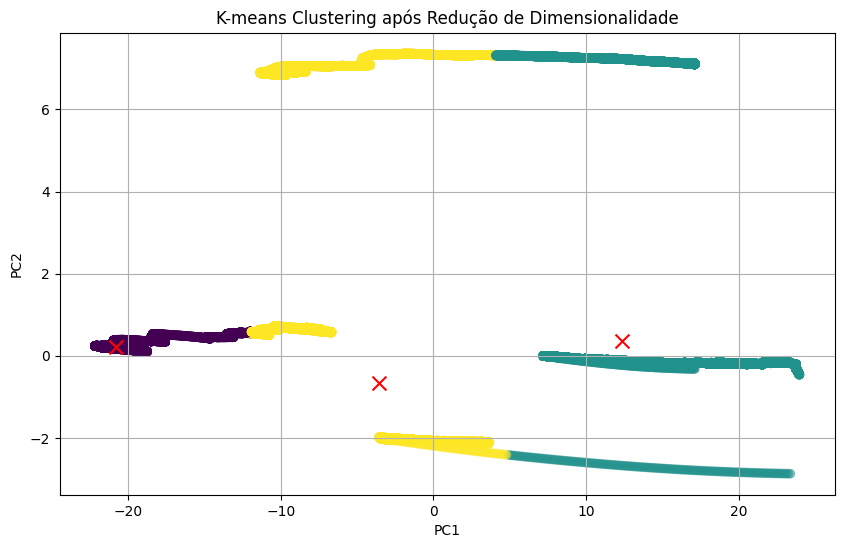

In [41]:
n_components = 4
pca = PCA(n_components=n_components)
scaler = StandardScaler()
X = scaler.fit_transform(df_preprocessing.drop(columns="class"))
X_pca = pca.fit_transform(X)
kmeans_six_variables(X_pca, n_clusters=3)

In [42]:
list_comp = [f"COMP_{x+1}"  for x in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=list_comp)
df_pca["class"] = df_preprocessing["class"].values

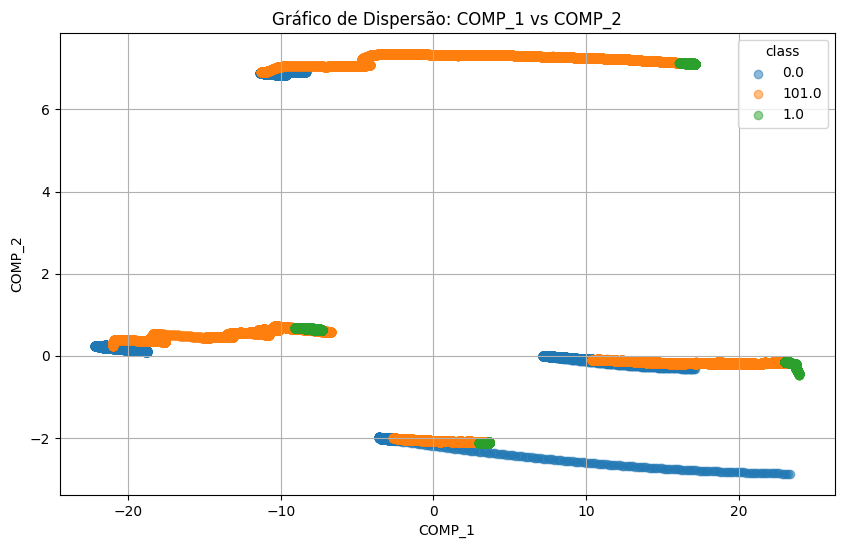

In [43]:
plot_two_variables(df_pca, 'COMP_1', 'COMP_2', binary_column="class")

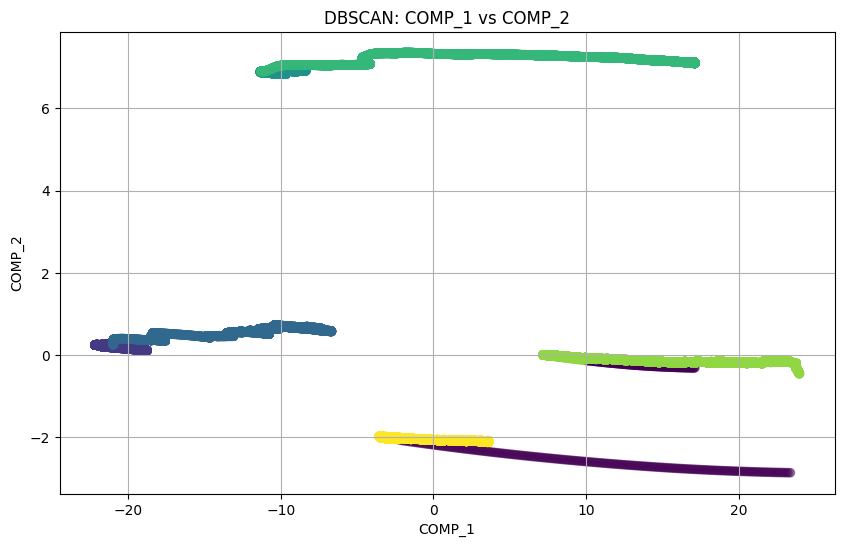

In [44]:
# Aplica o algoritmo DBSCAN
eps=0.05
min_samples=4
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_pca.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
plt.scatter(df_pca["COMP_1"], df_pca["COMP_2"], c=dbscan.labels_, cmap='viridis', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)
plt.show()

# Conclusão

- Dividiu bem, mas difícil dizer quem é falha e quem não é